In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tqdm import tqdm
import pandas as pd
import json

In [3]:
# ================================
# Paths
# ================================
ACTIVATION_DIR = (
    "/home/mahavirdabas18/programs/autoskill_safety/"
    "icml_exp_set3/activation_extraction_mistral_layer15/activations"
)

JSON_PATH = (
    "/home/mahavirdabas18/programs/autoskill_safety/"
    "icml_exp_set3/raw_data_artifcats/extracted_skills_per_query.json"
)

In [4]:
# ================================
# Load metadata (attack labels)
# ================================
with open(JSON_PATH, "r") as f:
    data = json.load(f)

assert isinstance(data, list), "Expected JSON to be a list"

attacks = [row["attack"] for row in data]
num_samples = len(attacks)

print(f"Loaded {num_samples} metadata rows")

Loaded 1494 metadata rows


In [5]:
# ================================
# Load activations
# ================================
activations = []

for i in tqdm(range(num_samples), desc="Loading activations"):
    path = os.path.join(ACTIVATION_DIR, f"activation_{i}.pt")
    act = torch.load(path, map_location="cpu")

    # Handle [1, d] vs [d]
    if act.ndim == 2 and act.shape[0] == 1:
        act = act.squeeze(0)

    assert act.ndim == 1, f"Bad shape at index {i}: {act.shape}"

    activations.append(act.numpy())

X = np.stack(activations)  # (N, D)
print(f"Activation matrix shape: {X.shape}")

Loading activations: 100%|██████████| 1494/1494 [00:00<00:00, 3588.86it/s]

Activation matrix shape: (1494, 4096)


In [6]:

# ================================
# PCA → 2D
# ================================
pca = PCA(n_components=2, random_state=0)
X_2d = pca.fit_transform(X)

print("Explained variance ratio:", pca.explained_variance_ratio_)

# ================================
# Prepare DataFrame for plotting
# ================================
df = pd.DataFrame({
    "pc1": X_2d[:, 0],
    "pc2": X_2d[:, 1],
    "attack": attacks,
})

Explained variance ratio: [0.126517   0.09010375]


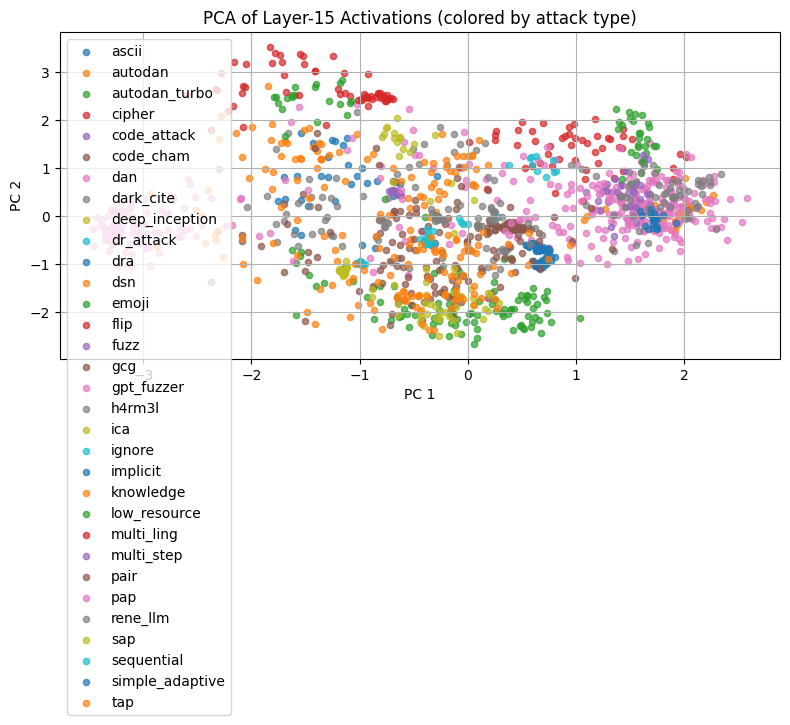

In [7]:
# ================================
# Plot
# ================================
plt.figure(figsize=(8, 6))

for attack_type in sorted(df["attack"].unique()):
    subset = df[df["attack"] == attack_type]
    plt.scatter(
        subset["pc1"],
        subset["pc2"],
        s=20,
        alpha=0.7,
        label=attack_type,
    )

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA of Layer-15 Activations (colored by attack type)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

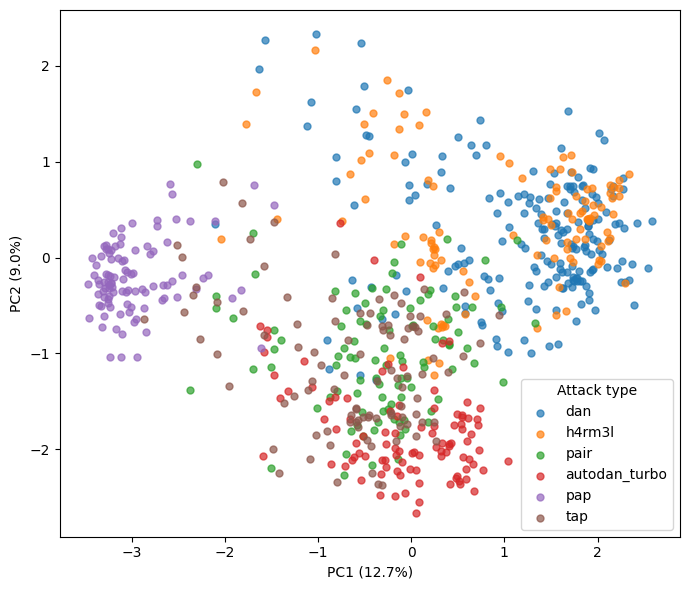

In [8]:
# keep only top-K most frequent attacks
TOP_K = 6

attack_counts = df["attack"].value_counts()
top_attacks = attack_counts.head(TOP_K).index

df_top = df[df["attack"].isin(top_attacks)]

plt.figure(figsize=(7, 6))
for atk in top_attacks:
    sub = df_top[df_top["attack"] == atk]
    plt.scatter(sub.pc1, sub.pc2, s=25, alpha=0.7, label=atk)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend(title="Attack type")
plt.tight_layout()
plt.show()

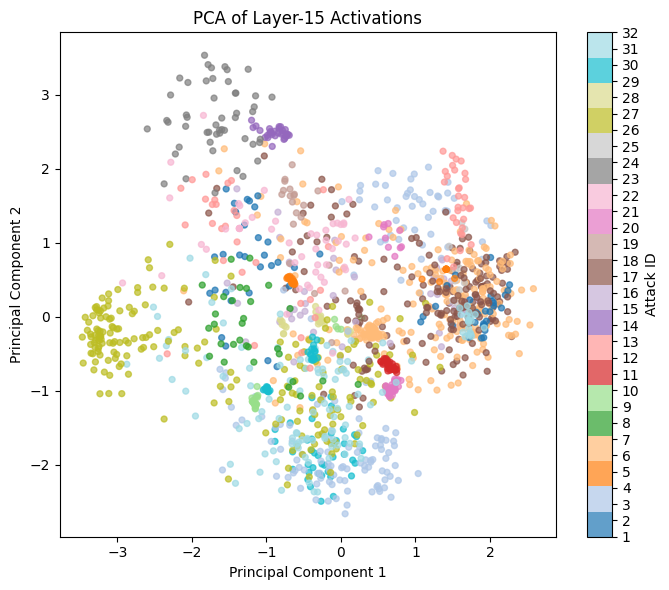

In [21]:
attack_types = sorted(df["attack"].unique())
attack_to_id = {a: i+1 for i, a in enumerate(attack_types)}
df["attack_id"] = df["attack"].map(attack_to_id)

plt.figure(figsize=(7, 6))

sc = plt.scatter(
    df.pc1,
    df.pc2,
    c=df.attack_id,
    cmap="tab20",
    s=18,
    alpha=0.7
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Layer-15 Activations")

cbar = plt.colorbar(sc, ticks=list(attack_to_id.values()))
cbar.set_label("Attack ID")

plt.tight_layout()

# ---- SAVE ----
plt.savefig("pca_layer15_attacks.png", dpi=2000, bbox_inches="tight")

plt.show()

In [22]:
legend_df = (
    pd.DataFrame({
        "ID": list(attack_to_id.values()),
        "Attack": list(attack_to_id.keys())
    })
    .sort_values("ID")
)

legend_df


,ID,Attack
0,1,ascii
1,2,autodan
2,3,autodan_turbo
3,4,cipher
4,5,code_attack
5,6,code_cham
6,7,dan
7,8,dark_cite
8,9,deep_inception
9,10,dr_attack


### Data Selection

In [11]:
K = 25

pca_25 = PCA(n_components=K, whiten=True, random_state=0)
Z = pca_25.fit_transform(X)   # shape: (N, 25)

print("PCA explained variance (sum):",
      pca_25.explained_variance_ratio_.sum())

PCA explained variance (sum): 0.64086676


In [12]:
def farthest_point_sampling(Z, max_B):
    """
    Z: (N, d) PCA-whitened features
    max_B: maximum budget (e.g., 150)

    Returns:
        selected_indices: list of length max_B
        min_distances: list of min distances at each step
    """
    N = Z.shape[0]

    # ---- deterministic first point: farthest from mean ----
    mean = Z.mean(axis=0, keepdims=True)
    dists = np.linalg.norm(Z - mean, axis=1)
    first_idx = np.argmax(dists)

    selected = [first_idx]

    # track min distance to selected set
    min_dist = np.linalg.norm(Z - Z[first_idx], axis=1)

    min_distances = [min_dist.max()]

    for _ in tqdm(range(1, max_B), desc="FPS selection"):
        next_idx = np.argmax(min_dist)
        selected.append(next_idx)

        # update min distances
        new_dist = np.linalg.norm(Z - Z[next_idx], axis=1)
        min_dist = np.minimum(min_dist, new_dist)

        min_distances.append(min_dist.max())

    return selected, min_distances


In [13]:
BUDGETS = [30, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 120, 150]
MAX_B = max(BUDGETS)

selected_indices, min_dist_curve = farthest_point_sampling(Z, MAX_B)

FPS selection: 100%|██████████| 149/149 [00:00<00:00, 5107.86it/s]


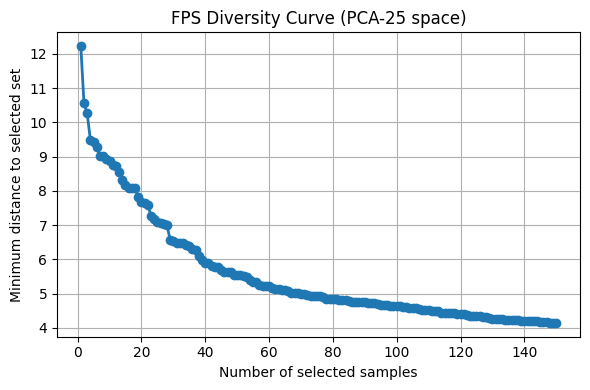

In [14]:
plt.figure(figsize=(6, 4))
plt.plot(
    range(1, MAX_B + 1),
    min_dist_curve,
    marker="o",
    linewidth=2
)
plt.xlabel("Number of selected samples")
plt.ylabel("Minimum distance to selected set")
plt.title("FPS Diversity Curve (PCA-25 space)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
OUTPUT_DIR = "./pca_selected"
os.makedirs(OUTPUT_DIR, exist_ok=True)

for B in BUDGETS:
    subset_indices = selected_indices[:B]

    # extract original rows
    output_data = [data[i] for i in subset_indices]

    # reset index implicitly by list order
    out_path = os.path.join(OUTPUT_DIR, f"pca_select_{B}.json")

    with open(out_path, "w") as f:
        json.dump(output_data, f, indent=4)

    print(f"Saved {B} samples → {out_path}")

Saved 30 samples → ./pca_selected/pca_select_30.json
Saved 50 samples → ./pca_selected/pca_select_50.json
Saved 55 samples → ./pca_selected/pca_select_55.json
Saved 60 samples → ./pca_selected/pca_select_60.json
Saved 65 samples → ./pca_selected/pca_select_65.json
Saved 70 samples → ./pca_selected/pca_select_70.json
Saved 75 samples → ./pca_selected/pca_select_75.json
Saved 80 samples → ./pca_selected/pca_select_80.json
Saved 85 samples → ./pca_selected/pca_select_85.json
Saved 90 samples → ./pca_selected/pca_select_90.json
Saved 95 samples → ./pca_selected/pca_select_95.json
Saved 100 samples → ./pca_selected/pca_select_100.json
Saved 105 samples → ./pca_selected/pca_select_105.json
Saved 110 samples → ./pca_selected/pca_select_110.json
Saved 120 samples → ./pca_selected/pca_select_120.json
Saved 150 samples → ./pca_selected/pca_select_150.json
